In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
 
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
 
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import keras as kr
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

%matplotlib inline

In [2]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv')
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv')
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv')
md = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)

In [3]:
gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv')
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv')
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv')
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [4]:
result = pd.merge(md, gammadata, on='cindex')

Y = result.iloc[:, -1]
Y = np.array(Y, dtype = np.float32)
Y=Y/45000

data = result.iloc[:, 1:-4]

In [5]:
data = data[data.T[data.dtypes!=np.object].index]

In [6]:
descriptors = data.values

In [7]:
descriptors_std = StandardScaler().fit_transform(descriptors)

In [8]:
pca = PCA(n_components=100)
descriptors_2d = pca.fit_transform(descriptors_std)

In [9]:
descriptors_pca= pd.DataFrame(descriptors_2d)
#descriptors_pca.index = data.index
#descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
#descriptors_pca

In [10]:
X = descriptors_pca

In [11]:
X = np.array(X, dtype = np.float32)
st = StandardScaler()
X= st.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 30, input_dim = X.shape[1]))
model.add(Activation("sigmoid"))
model.add(tf.keras.layers.Dropout(0.03))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
activation (Activation)      (None, 30)                0         
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 3,061
Trainable params: 3,061
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 32,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Test loss: 0.017655441537499428
Test accuracy: 0.0
Neural Network RMS 0.150254249666576


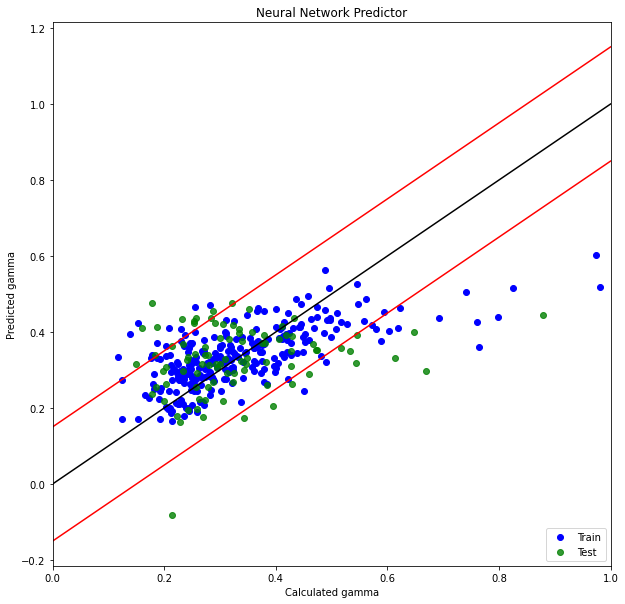

In [14]:
plt.figure(figsize=(10,10))
plt.title('Neural Network Predictor')
plt.xlim(0,1)
#plt.ylim(0,1)
plt.xlabel('Calculated gamma')
plt.ylabel('Predicted gamma')
plt.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
plt.scatter(y_test, model.predict(X_test), c = 'green', label = 'Test', alpha = 0.8)
plt.plot([0,1],[0,1],c = 'k')
plt.plot([0,1],[0+rms,1+rms],c = 'r')
plt.plot([0,1],[0-rms,1-rms],c = 'r')
plt.legend(loc = 4)
#plt.savefig('Neural Network Predictor.png', dpi=500)
plt.show()

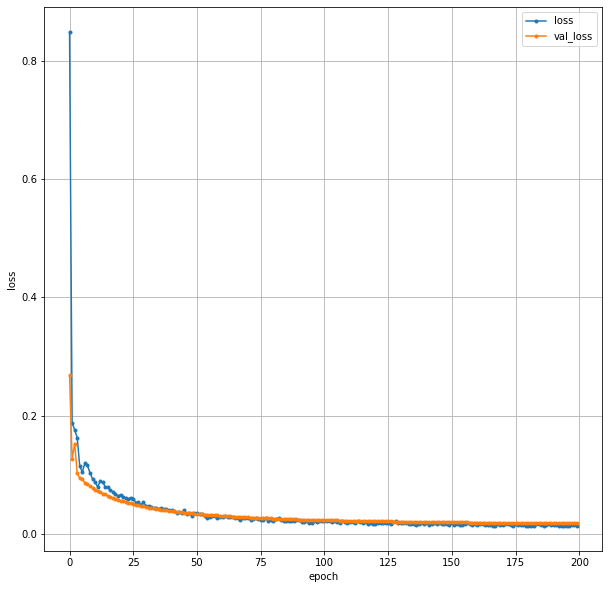

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.figure(figsize=(10,10))
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig('loss & val_loss for epochs.png', dpi=500)
plt.show()